In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import pandas as pd
from astropy import units as u

from astroquery.gaia import Gaia
from astropy.io.votable import parse


pd.options.mode.chained_assignment = None

def votable_to_pandas(votable_file):
    votable = parse(votable_file)
    table = votable.get_first_table().to_table(use_names_over_ids=True)
    return table.to_pandas()

## Enfoque en el primer cascaron (0,1000) pc. Se toman todas las estrellas en gedr3dist.main con r_med_geo<1000

In [2]:
real= votable_to_pandas('within1000-result.vot.gz') #toma alrededor de 3 minutos leer el archivo
real.dropna(inplace=True)
len(real)

2500666

In [3]:
from scipy.interpolate import CubicSpline as cs
real.sort_values('parallax', inplace=True)
distance = cs(real.parallax, real.r_med_geo)

distance(real.parallax.min()), real.parallax.min(),real.parallax.max() #this is the parallax used as inferior limit for the mock catalogue stars

(array(997.60046387), 0.9421950018394017, 304.1353692001036)

In [4]:
real.parallax.min(), real.parallax.max()

(0.9421950018394017, 304.1353692001036)

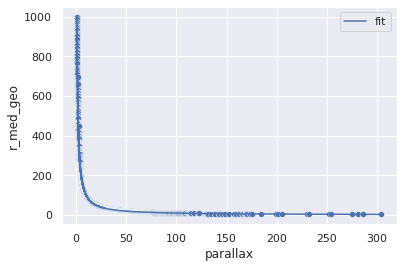

In [5]:
plt.figure()
sns.scatterplot(data=real, x='parallax', y='r_med_geo')
sns.lineplot(data=real, x='parallax', y=distance(real.parallax), label='fit')
plt.legend()

In [6]:
#results= mock catalogue
results=votable_to_pandas('mock_1000-result.vot.gz') #toma alrededor de 12 minutos
len(results)

14122900

In [7]:
results.dropna(inplace=True)
results= results.sample(len(real))
len(results)

2500666

In [8]:
results.head()

,source_id,ra,dec,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,radial_velocity,radial_velocity_error
11482720,1812801924936761347,7.994274,44.246919,1.158829,0.055109,-8.329351,0.030640,-0.143132,0.027334,-48.616821,6.769678
3057296,1837411005211082753,16.865464,-5.405934,2.204211,0.051550,45.199158,0.028662,-27.065672,0.025569,-29.576218,2.176717
1992946,2202286335748734978,34.863124,62.919609,1.654231,0.052229,7.944239,0.029039,-7.141990,0.025905,25.068565,2.122030
2876112,2079563172888444930,206.724653,-39.264209,4.701624,0.050828,-20.437208,0.028260,-11.457412,0.025211,76.885742,3.305204
13948305,2058463995588771841,201.027448,-53.385489,1.033757,0.052687,-2.629788,0.029294,-2.762620,0.026133,-7.728067,1.000000


## Stars with radial_velocity_error, pmra_error, pmdec_error and parallax_error greater than 10% are left out. done with query on gaia archive.

In [9]:
results.head()

,source_id,ra,dec,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,radial_velocity,radial_velocity_error
11482720,1812801924936761347,7.994274,44.246919,1.158829,0.055109,-8.329351,0.030640,-0.143132,0.027334,-48.616821,6.769678
3057296,1837411005211082753,16.865464,-5.405934,2.204211,0.051550,45.199158,0.028662,-27.065672,0.025569,-29.576218,2.176717
1992946,2202286335748734978,34.863124,62.919609,1.654231,0.052229,7.944239,0.029039,-7.141990,0.025905,25.068565,2.122030
2876112,2079563172888444930,206.724653,-39.264209,4.701624,0.050828,-20.437208,0.028260,-11.457412,0.025211,76.885742,3.305204
13948305,2058463995588771841,201.027448,-53.385489,1.033757,0.052687,-2.629788,0.029294,-2.762620,0.026133,-7.728067,1.000000


In [10]:
#calculating distances. Hay un problema sobre cómo Cubic Spline predice a partir de paralajes muy precisos.
results['r_med_geo']= distance(np.round(results['parallax'],0))

In [11]:
results.r_med_geo.max(), results.r_med_geo.min()

(973.7291935837393, 3.967783949561896)

## Gaia_simulation no tiene l ni b. Entonces se hace la conversión a partir de ra y dec.

In [12]:
from astropy.coordinates import SkyCoord

In [13]:
results['l']= SkyCoord(ra=results.ra*u.degree, dec=results.dec*u.degree, frame='icrs').galactic.l.value
results['b']= SkyCoord(ra=results.ra*u.degree, dec=results.dec*u.degree, frame='icrs').galactic.b.value

In [14]:
results.head()

,source_id,ra,dec,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,radial_velocity,radial_velocity_error,r_med_geo,l,b
11482720,1812801924936761347,7.994274,44.246919,1.158829,0.055109,-8.329351,0.030640,-0.143132,0.027334,-48.616821,6.769678,973.729194,119.259074,-18.486001
3057296,1837411005211082753,16.865464,-5.405934,2.204211,0.051550,45.199158,0.028662,-27.065672,0.025569,-29.576218,2.176717,492.185240,133.605956,-67.944979
1992946,2202286335748734978,34.863124,62.919609,1.654231,0.052229,7.944239,0.029039,-7.141990,0.025905,25.068565,2.122030,492.185240,132.757041,1.739026
2876112,2079563172888444930,206.724653,-39.264209,4.701624,0.050828,-20.437208,0.028260,-11.457412,0.025211,76.885742,3.305204,198.945808,314.505005,22.357964
13948305,2058463995588771841,201.027448,-53.385489,1.033757,0.052687,-2.629788,0.029294,-2.762620,0.026133,-7.728067,1.000000,973.729194,307.856010,9.173603


## Sky grid

### Building spheric cubes

In [15]:
class Cube:
  def __init__(self, id, li, lf,bi,bf, ri,rf):
    self.id = id
    self.li = li
    self.lf = lf
    self.bi = bi
    self.bf = bf
    self.ri = ri
    self.rf = rf
    self.stars = pd.DataFrame()
    self.avgpmra= pd.NA
    self.avgpmdec= pd.NA
    self.pmra_std= pd.NA
    self.pmdec_std= pd.NA
    self.pmra_outliers= pd.DataFrame()
    self.pmdec_outliers= pd.DataFrame()
    self.pmra_rms= pd.NA
    self.pmdec_rms= pd.NA
    self.pmra_outlier_ratio= pd.NA
    self.pmdec_outlier_ratio= pd.NA
    self.both_outlier_ratio= pd.NA

In [27]:
#Particiones de los intervalos, longitud, latitud, distancia.
#Este algoritmo asume particiones regulares para todos los intervalos.
r=1000
nl= 20 
nb= 20
nr= 20

ls= np.linspace(0,360,nl) 
bs= np.linspace(-90,90,nb)

length_l= 360/nl

def rf(thetai, thetaf, ri):
  k=np.radians(length_l)*(np.sin(np.radians(thetaf)-np.sin(np.radians(thetai))))
  V= r**3/3 * k
  return (3*(V/(nr-1))/k + ri**3)**(1/3)

cubes=[0]*((nl-1)*(nb-1)*(nr-1))

cubes_frontera=[0]*nr
cubes_frontera[0]=Cube(0, ls[0], ls[1], bs[0], bs[1], 0,0)


counter=0
for i in range(nr-1):
  for j in range(nb-1):
    for k in range(nl-1):
      cubes[counter]=Cube(counter, ls[k] , ls[k+1], bs[j], bs[j+1], cubes_frontera[i].rf, rf(bs[j], bs[j+1],cubes_frontera[i].rf))
      counter+=1
  cubes_frontera[i+1]= cubes[counter-1]

In [28]:
len(cubes)

6859

### Now, we need to add each star to its cube.

The filters by distance only work if the angular lengths of the spheric cube are small enough. If this condition isn't met, errors could appear. This is due to compare distances along axis (the cube's and the star's) that are not totally parallel.

In [30]:
for cube in cubes:  
  cube.stars = results.query(f'l<{cube.lf} & l>{cube.li} & b<{cube.bf} & b>{cube.bi} & r_med_geo<{cube.rf} & r_med_geo>{cube.ri}')
  cube.stars['cube_id']= cube.id
  if len(cube.stars)!=0:
    cube.avgpmra = cube.stars.pmra.mean()
    cube.avgpmdec = cube.stars.pmdec.mean()
    cube.pmra_std= np.std(cube.stars.pmra)
    cube.pmdec_std= np.std(cube.stars.pmdec)

## Finding outliers

Any star with any of its proper motion features (pmra, pmdec) beyond $\mu \pm 3σ$ of its cube is considered as an outlier

In [37]:
for cube in cubes:
  if len(cube.stars)!=0:
    cube.stars['pmra_deviation'] = cube.avgpmra - cube.stars.pmra
    cube.stars['pmdec_deviation'] = cube.avgpmdec - cube.stars.pmdec

In [38]:
for cube in cubes:
  if len(cube.stars)!=0:
    cube.pmra_outliers= cube.stars.query(f'pmra_deviation<{-3*cube.pmra_std} | pmra_deviation>{3*cube.pmra_std}')
    cube.pmdec_outliers= cube.stars.query(f'pmdec_deviation<{-3*cube.pmdec_std} | pmdec_deviation>{3*cube.pmdec_std}')

### Calculating outliers ratio and rms

In [39]:
for cube in cubes:
  if len(cube.stars)!=0:
    cube.pmra_outlier_ratio= len(cube.pmra_outliers)/len(cube.stars)
    if len(cube.pmra_outliers)!=0:
      cube.pmra_rms= np.sqrt(np.sum((cube.avgpmra - cube.pmra_outliers.pmra)**2)/len(cube.pmra_outliers))
    

    cube.pmdec_outlier_ratio= len(cube.pmdec_outliers)/len(cube.stars) 
    if len(cube.pmdec_outliers)!=0:
      cube.pmdec_rms= np.sqrt(np.sum((cube.avgpmdec - cube.pmdec_outliers.pmdec)**2)/len(cube.pmdec_outliers))
      cube.pmdec_outlier_ratio= len(cube.pmdec_outliers)/len(cube.stars)
    
    cube.both_outlier_ratio= len(set(cube.pmra_outliers.source_id) & set(cube.pmdec_outliers.source_id))/len(cube.stars)

## RMS Distribution

In [40]:
df_cubes= pd.DataFrame({
    'id': [ cube.id for cube in cubes],
    'r_med': [(np.round(cube.ri,3) + np.round(cube.rf,3))/2 for cube in cubes],
    'l_med': [(cube.li + cube.lf)/2 for cube in cubes],
    'b_med': [(cube.bi + cube.bf)/2 for cube in cubes],
    'pmra': [ cube.avgpmra for cube in cubes],
    'pmdec': [ cube.avgpmdec for cube in cubes],
    'std_pmra': [cube.pmra_std for cube in cubes],
    'std_pmdec': [cube.pmdec_std for cube in cubes],
    'pmra_rms': [cube.pmra_rms for cube in cubes],
    'pmdec_rms': [cube.pmdec_rms for cube in cubes],
    'pmra_outlier_ratio': [cube.pmra_outlier_ratio for cube in cubes],
    'pmdec_outlier_ratio': [cube.pmdec_outlier_ratio for cube in cubes],
    'both_outlier_ratio': [cube.both_outlier_ratio for cube in cubes]
})
df_cubes.dropna(inplace=True)

### ¿Cómo cambian los ratios de outliers a medida que nos alejamos del sol?

In [41]:
ratio_means= df_cubes.astype(float).groupby('r_med').mean()
ratio_l_means= df_cubes.astype(float).groupby('l_med').mean()
ratio_b_means= df_cubes.astype(float).groupby('b_med').mean()

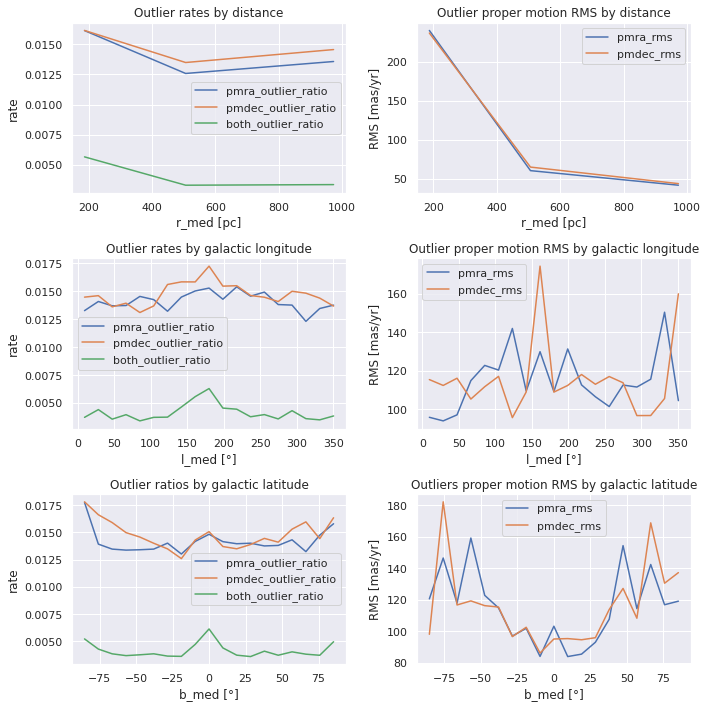

In [42]:
plt.figure(figsize=(10,10))
ax= plt.subplot(3,2,1)
ax.set_title('Outlier rates by distance')
sns.lineplot(data= ratio_means,x='r_med', y='pmra_outlier_ratio', label='pmra_outlier_ratio', ax=ax)
sns.lineplot(data= ratio_means,x='r_med', y='pmdec_outlier_ratio', label='pmdec_outlier_ratio', ax=ax)
sns.lineplot(data= ratio_means,x='r_med', y='both_outlier_ratio', label='both_outlier_ratio', ax=ax)
ax.set_xlabel('r_med [pc]')
ax.set_ylabel('rate')


ax1=plt.subplot(3,2,2)
ax1.set_title('Outlier proper motion RMS by distance')
sns.lineplot(data= ratio_means,x='r_med', y='pmra_rms', label='pmra_rms',  ax=ax1)
sns.lineplot(data= ratio_means,x='r_med', y='pmdec_rms', label='pmdec_rms',  ax=ax1)
ax1.set_xlabel('r_med [pc]')
ax1.set_ylabel('RMS [mas/yr]')


ax2=plt.subplot(3,2,3)
ax2.set_title('Outlier rates by galactic longitude')
sns.lineplot(data= ratio_l_means,x='l_med', y='pmra_outlier_ratio', label='pmra_outlier_ratio', ax=ax2)
sns.lineplot(data= ratio_l_means,x='l_med', y='pmdec_outlier_ratio', label='pmdec_outlier_ratio', ax=ax2)
sns.lineplot(data= ratio_l_means,x='l_med', y='both_outlier_ratio', label='both_outlier_ratio', ax=ax2)
ax2.set_xlabel('l_med [°]')
ax2.set_ylabel('rate')

ax3=plt.subplot(3,2,4)
ax3.set_title('Outlier proper motion RMS by galactic longitude')
sns.lineplot(data= ratio_l_means,x='l_med', y='pmra_rms', label='pmra_rms', ax=ax3)
sns.lineplot(data= ratio_l_means,x='l_med', y='pmdec_rms', label='pmdec_rms', ax=ax3)
ax3.set_xlabel('l_med [°]')
ax3.set_ylabel('RMS [mas/yr]')


ax4=plt.subplot(3,2,5)
ax4.set_title('Outlier ratios by galactic latitude')
sns.lineplot(data= ratio_b_means,x='b_med', y='pmra_outlier_ratio', label='pmra_outlier_ratio', ax=ax4)
sns.lineplot(data= ratio_b_means,x='b_med', y='pmdec_outlier_ratio', label='pmdec_outlier_ratio', ax=ax4)
sns.lineplot(data= ratio_b_means,x='b_med', y='both_outlier_ratio', label='both_outlier_ratio', ax=ax4)
ax4.set_xlabel('b_med [°]')
ax4.set_ylabel('rate')

ax6=plt.subplot(3,2,6)
ax6.set_title('Outliers proper motion RMS by galactic latitude')
sns.lineplot(data= ratio_b_means,x='b_med', y='pmra_rms', label='pmra_rms', ax=ax6)
sns.lineplot(data= ratio_b_means,x='b_med', y='pmdec_rms', label='pmdec_rms', ax=ax6)
ax6.set_xlabel('b_med [°]')
ax6.set_ylabel('RMS [mas/yr]')


plt.legend()
plt.tight_layout()
plt.show()

### pmra and pmdec outliers

In [59]:
pmra_outliers= pd.concat([ cube.pmra_outliers for cube in cubes if len(cube.pmra_outliers)!=0],axis=0)
pmdec_outliers= pd.concat([ cube.pmdec_outliers for cube in cubes if len(cube.pmra_outliers)!=0],axis=0)

### both pmra and pmdec outliers

In [60]:
common= pd.DataFrame(list(set(pmra_outliers.source_id) & set(pmdec_outliers.source_id)), columns=['source_id'])
both_outliers= pd.merge(common,results, on=['source_id'])

## Exporting files as csv

In [61]:
cubos= pd.DataFrame({
    'r_med': [(cube.ri + cube.rf)/2 for cube in cubes],
    'l_med': [(cube.li + cube.lf)/2 for cube in cubes],
    'b_med': [(cube.bi + cube.bf)/2 for cube in cubes],
    'pmra': [ cube.avgpmra for cube in cubes],
    'pmdec': [ cube.avgpmdec for cube in cubes],
    'std_pmra': [cube.pmra_std for cube in cubes],
    'std_pmdec': [cube.pmdec_std for cube in cubes]
})

In [68]:
#cubos
cubos.to_csv('cubos_mock.csv')

#En pmra, pmdec
pmra_outliers.to_csv('pmra_outliers_mock.csv')
pmdec_outliers.to_csv('pmdec_outliers_mock.csv')

#En ambos
both_outliers.to_csv('both_outliers_mock.csv')

## Heatmaps

In [69]:
maps = [df_cubes.query(f'r_med=={dist}') for dist in df_cubes.r_med.unique()]